In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Read a pandas DataFrame
data = pd.read_csv('AAPL.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ts_polarity,twitter_volume
0,2016-01-04,25.65,26.34,25.50,26.34,24.44,270597600,0.070389,1133.0
1,2016-01-05,26.44,26.46,25.60,25.68,23.83,223164000,0.133635,1430.0
2,2016-01-06,25.14,25.59,24.97,25.17,23.36,273829600,0.072042,1949.0
3,2016-01-07,24.67,25.03,24.11,24.11,22.38,324377600,0.074369,2289.0
4,2016-01-08,24.64,24.78,24.19,24.24,22.50,283192000,0.051595,2235.0


In [2]:
from sklearn.preprocessing import MinMaxScaler

data['ts_polarity'] = data['ts_polarity'].interpolate()
data['twitter_volume'] = data['twitter_volume'].interpolate()

# Select features for the model
features = data[['Open', 'High', 'Low', 'Adj Close', 'ts_polarity', 'twitter_volume']]
target = data['Close']

In [3]:
# Normalize features
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)
scaled_target = scaler_target.fit_transform(target.values.reshape(-1,1))

In [4]:
import numpy as np

# Helper function to create sequences
def create_dataset(features, target, look_back=30):
    dataX, dataY = [], []
    for i in range(len(features) - look_back):
        a = features[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(target[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Create dataset for LSTM
X, y = create_dataset(scaled_features, scaled_target)

train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
trainX, trainY = X[0:train_size], y[0:train_size]
testX, testY = X[train_size:], y[train_size:]

trainX.shape, trainY.shape, testX.shape, testY.shape

((926, 30, 6), (926,), (232, 30, 6), (232,))

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Build the LSTM model
model = Sequential([
    # LSTM(512, return_sequences=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), input_shape=(trainX.shape[1], trainX.shape[2])),
    # Dropout(0.2),
    # BatchNormalization(),
    # LSTM(256, return_sequences=True, kernel_regularizer=l2(0.01)),
    # Dropout(0.2),
    # BatchNormalization(),
    # LSTM(128),
    # Dropout(0.2),
    LSTM(32, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])),
    LSTM(16),
    Dense(1),
    Activation('linear')
])
# step_size = 1
# model = Sequential()
# model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
# model.add(LSTM(16))
# model.add(Dense(1))
# model.add(Activation('linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(trainX, trainY, epochs=10, batch_size=1, validation_data=(testX, testY), verbose=1, callbacks=[early_stop])

Epoch 1/10
926/926 [==============================] - 11s 7ms/step - loss: 7.7845e-04 - val_loss: 0.0105
Epoch 2/10
926/926 [==============================] - 8s 8ms/step - loss: 2.0941e-04 - val_loss: 0.0017
Epoch 3/10
926/926 [==============================] - 8s 8ms/step - loss: 1.7241e-04 - val_loss: 0.0057
Epoch 4/10
926/926 [==============================] - 7s 7ms/step - loss: 1.5705e-04 - val_loss: 0.0026
Epoch 5/10
926/926 [==============================] - 8s 9ms/step - loss: 1.4543e-04 - val_loss: 0.0041
Epoch 6/10
926/926 [==============================] - 7s 8ms/step - loss: 1.1107e-04 - val_loss: 0.0024
Epoch 7/10
926/926 [==============================] - 7s 8ms/step - loss: 1.2358e-04 - val_loss: 0.0013
Epoch 8/10
926/926 [==============================] - 6s 7ms/step - loss: 9.3485e-05 - val_loss: 0.0025
Epoch 9/10
926/926 [==============================] - 6s 6ms/step - loss: 7.9707e-05 - val_loss: 8.6985e-04
Epoch 10/10
926/926 [==============================] - 5s 6

In [6]:
from sklearn.metrics import mean_squared_error

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

NameError: name 'math' is not defined

1/1 [==============================] - 1s 505ms/step


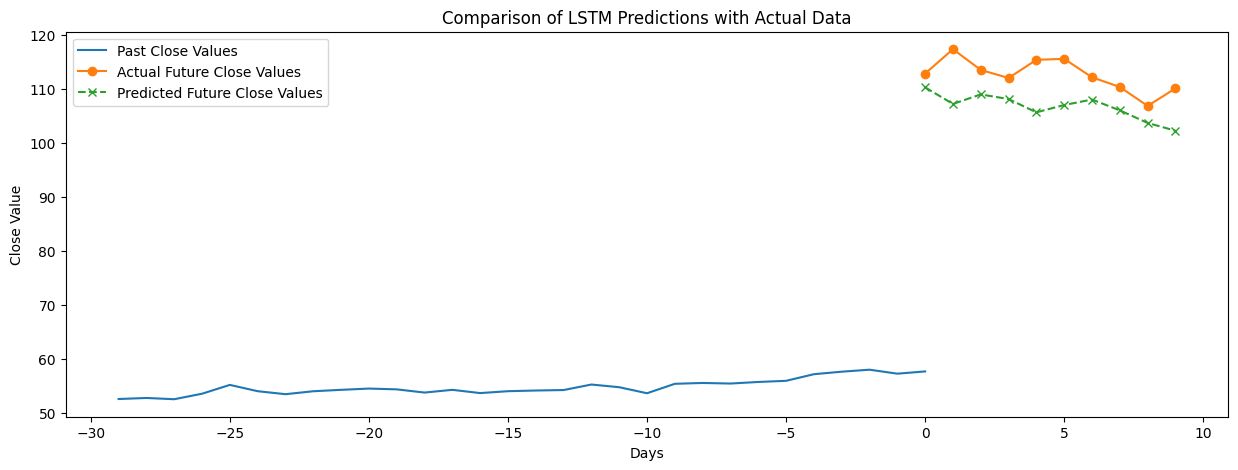

In [7]:
last_sequence = testX[-10:,:,:]
predicted_output = model.predict(last_sequence)
predicted_output = scaler_target.inverse_transform(predicted_output)
actual_output = scaler_target.inverse_transform(testY[-10:].reshape(-1, 1))

# Plotting
plt.figure(figsize=(15, 5))
plt.plot(range(-29, 1), scaler_target.inverse_transform(trainX[-1][:, 0].reshape(-1, 1)), label='Past Close Values')
plt.plot(range(0, 10), actual_output, marker='o', label='Actual Future Close Values')
plt.plot(range(0, 10), predicted_output, marker='x', linestyle='--', label='Predicted Future Close Values')
plt.title('Comparison of LSTM Predictions with Actual Data')
plt.xlabel('Days')
plt.ylabel('Close Value')
plt.legend()
plt.show()